In [1]:
#let's import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#Let's import the data set
#"A: AUSTRALIA", "E:EURO", "J:JAPANESE","T"DATE," U:UK"
df= pd.read_csv("C.csv",parse_dates=["T"],index_col="T")
print(df.shape)  
df.tail()

(5217, 4)


,A,E,U,J
T,,,,
2019-12-25,0.0000,0.0000,0.0000,0.00
2019-12-26,1.4411,0.9007,0.7688,109.67
2019-12-27,1.4331,0.8949,0.7639,109.47
2019-12-30,1.4278,0.8915,0.7610,108.85
2019-12-31,1.4225,0.8907,0.7536,108.67


C:\Users\Rodgers\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


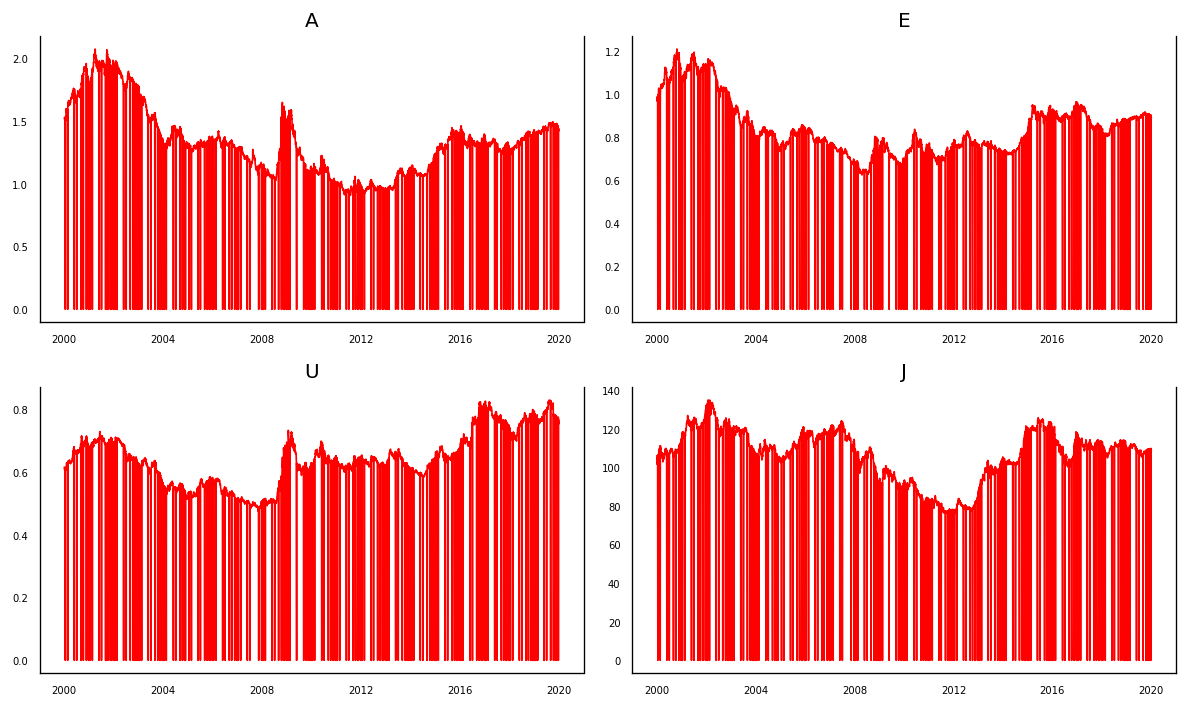

In [3]:
# Plot the series to take a look at what the data set looks like.
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [4]:
#Granger Cauality matrix
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test = 'ssr_chi2test'
#This function takes two arguments, your data and the variables in your columns, makes all combinations of the four time series
#models and ouputs a p value with the causation p values as it's elements.
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
            df.columns = [var + '_x' for var in variables]
            df.index = [var + '_y' for var in variables]
            return df

grangers_causation_matrix(df, variables = df.columns) 
#we can see below from the matrix that the p values are less than the critical value(alpha). Which means that the series Granger
#cause each other. Let's take a look at what the series looks like.

,A_x,E_x,U_x,J_x
A_y,1.0,0.0,0.0,0.0
E_y,0.0,0.0,0.0,0.0
U_y,0.0,0.0,0.0,0.0
J_y,0.0,0.0,0.0,0.0


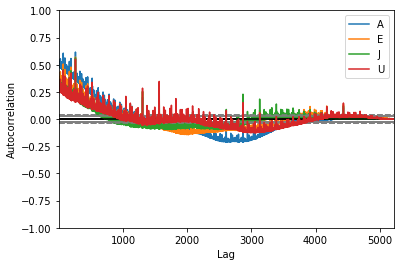

In [5]:
#plotting autocorellation graphs
pd.plotting.autocorrelation_plot(df.A,label='A')
pd.plotting.autocorrelation_plot(df.E,label='E')
pd.plotting.autocorrelation_plot(df.J,label='J')
pd.plotting.autocorrelation_plot(df.U,label='U')
plt.show()

In [6]:
#split the data into training and testing sets
train, test=df[0:3748], df[3748:-1]
#check the size of the data sets:
print(train.shape) # The training set has 3748 data points

(3748, 4)


In [7]:
#remove seasonality from the data set
t=train.diff().dropna()

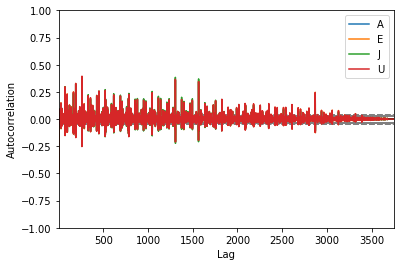

In [8]:
#plotting the differenced time series. That's the differenced data.The plot looks quite different from what we had above.
pd.plotting.autocorrelation_plot(t.A,label='A')
pd.plotting.autocorrelation_plot(t.E,label='E')
pd.plotting.autocorrelation_plot(t.J,label='J')
pd.plotting.autocorrelation_plot(t.U,label='U')
plt.show()

In [100]:
#Granger Causality test on differenced data
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(t[['A','E']], maxlag=1, addconst=True, verbose=True))
print(grangercausalitytests(t[['J','U']], maxlag=1, addconst=True, verbose=True))
print(grangercausalitytests(t[['U','E']], maxlag=1, addconst=True, verbose=True))
#We can see that the p-values are larger than 0.05, we can conclude that the series do not granger cause one another


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0030  , p=0.9567  , df_denom=3743, df_num=1
ssr based chi2 test:   chi2=0.0030  , p=0.9566  , df=1
likelihood ratio test: chi2=0.0030  , p=0.9566  , df=1
parameter F test:         F=0.0030  , p=0.9567  , df_denom=3743, df_num=1
{1: ({'ssr_ftest': (0.002952928181574514, 0.95666650262462, 3743.0, 1), 'ssr_chi2test': (0.002955294942072704, 0.9566462561310316, 1), 'lrtest': (0.0029552937758126063, 0.9566462646770413, 1), 'params_ftest': (0.0029529281814450687, 0.95666650262462, 3743.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000236A14E4448>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000236A1505108>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0011  , p=0.9738  , df_denom=3743, df_num=1
ssr based chi2 test:   chi2=0.0011  , p=0.9738  , df=1
likelihood ratio test: chi2=0.0011  , p=0.9

In [104]:
#Running the VAR model.
mod = smt.VAR(t)
res = mod.fit(maxlags=15, ic='aic')
print(res.summary())

C:\Users\Rodgers\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Apr, 2020
Time:                     17:24:38
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -16.0860
Nobs:                     3734.00    HQIC:                  -16.3137
Log likelihood:           9711.19    FPE:                7.25171e-08
AIC:                     -16.4395    Det(Omega_mle):     6.85420e-08
--------------------------------------------------------------------
Results for equation A
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000327         0.004384           -0.075           0.940
L1.A         -0.815937         0.153266           -5.324           0.000
L1.E          0.041147         0.362799            0.113           0.910
L1.U         -0.118569 